In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import torch
import random
import re

%matplotlib inline

# Machine learning imports: 
(NOTE: much of this is based on Anisha's code for the TnSeq project)

In [2]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

Setting paths

In [3]:
EMB_PATH = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/mohammed/sdr_reprs_45'
# EMB_PATH = '/Users/ajinich/Dropbox (Personal)/KyuRhee/unknown_function/unknown_redox/data/mohammed/sdr_reprs_345'
EMB_LAYER = 33

In [4]:
cols = sns.color_palette("tab10")

# Functions: 

In [5]:
# Credit to Anisha Zaveri
def log_regression(X, y, n_classes=2, n_splits=5, norm_method='SMOTE', C=1):
    
    accuracy = []
    log_loss_var = []
    confusion = np.zeros((n_classes, n_classes))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # REVIEW THIS: What is this, SMOTE? 
        if norm_method == 'SMOTE':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=13)

        elif norm_method == 'bal_weights':
            clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, class_weight='balanced', random_state=13)

        elif norm_method == None:
            clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=13)

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))        
        y_pred = clf.predict_proba(X_test)
        log_loss_var.append(log_loss(y_test, y_pred))

    confusion = normalize(confusion, axis=1, norm='l1')
    
    return accuracy, confusion, log_loss_var, clf

In [6]:
# Credit to Anisha Zaveri
def xgbc_tree(X, y, n_classes=2, n_splits=5, reg_param=10):
    
    accuracy = []
    log_loss_var = []
    confusion = np.zeros((n_classes, n_classes))

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in skf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # norm_method == 'SMOTE':
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        clf = XGBClassifier(gamma = reg_param, reg_alpha=1, reg_lambda=1)

        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))        
        y_pred = clf.predict_proba(X_test)
        log_loss_var.append(log_loss(y_test, y_pred))

    confusion = normalize(confusion, axis=1, norm='l1')
    return accuracy, confusion, log_loss_var, clf

In [7]:
def plot_logloss_acc(C_list, list_accuracy, list_log_loss, title_str, file_name, ymax):
    plt.figure(figsize = (10,6))
    plt.plot(np.log10(C_list), list_accuracy, '-o')
    plt.ylim(0, 1)
    plt.xlabel('accuracy', fontsize = 20)
    # yl = plt.ylabel('cross entropy', fontsize = 20)

    plt.plot(np.log10(C_list), list_log_loss, '-o')
    plt.xticks(np.log10(C_list))
    plt.ylim(0, ymax)
    plt.xlabel('log10 inverse\nregularization param. (C)', fontsize = 20)
    yl = plt.ylabel('error metric', fontsize = 20)
    leg = plt.legend(['Accuracy', 'LogLoss'], fontsize = 14)
    plt.title(title_str, fontsize = 20)
    plt.tight_layout()
    plt.savefig(os.path.join(path_fig, file_name), dpi=250)

In [8]:
def strat_by_SSN(thresh, clus_train, df_data_class, X, Y):

    # Load SSN cluster mapping file: 
    path = '../../data/mohammed/EFI_SSN_clusters/EFI_SSN_SDR_45/'
    file_name = 'SDR_45_score_thresh_'+str(thresh)+'_ssn_cluster_mapping.txt'
    file_ssn = os.path.join(path, file_name)
    df_ssn = pd.read_csv(file_ssn, sep='\t')
    df_ssn.rename(columns={'UniProt ID':'Entry', 'Cluster Number':'ClusterNum'}, inplace=True)

    # Set the remainder of the clusters as "test" clusters. 
    clus_test = [c for c in df_ssn.ClusterNum.unique().tolist() if c not in clus_train]
    # what fraction of SDRs are in the training set? 
    list_train = df_ssn[df_ssn.ClusterNum.isin(clus_train)].Entry.tolist()
    # list_test = df_ssn[df_ssn.ClusterNum.isin(clus_test)].Entry.tolist()
    # alternative: get the remainder/complement of entries: 
    list_test = df_data_class[~df_data_class.Entry.isin(list_train)].Entry.tolist()

    # Get indices for test and training sets: 
    train_index = df_data_class[df_data_class.Entry.isin(list_train)].index.tolist()
    test_index = df_data_class[df_data_class.Entry.isin(list_test)].index.tolist()

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    print('fraction of enzymes in the training set:')
    print( np.round(len(train_index) / df_data_class.shape[0],2))
    print('\nfraction of enzymes in True category in the test set:') 
    print(np.round(len([y for y in y_test if y==1])/len(y_test),2))

    return X_train, X_test, y_train, y_test


In [9]:
def plot_real_vs_shuffled_metric(df_accuracy, list_df_accuracy_SHFL, C, metric, model, cols, xymin = 0.35, xymax = 0.85, title_str = 'NAD_NADP'):
    
    metric_true = df_accuracy[df_accuracy.C_reg==C][metric].values
    list_metric_shfl = [ df[df.C_reg == C][metric].values for df in list_df_accuracy_SHFL ]
    # error bars: 
    metric_shfl_pc95 = np.array([np.percentile([ll[i] for ll in list_metric_shfl], 95) for i in range(len(list_metric_shfl[0]))])
    metric_shfl_pc5 = np.array([np.percentile([ll[i] for ll in list_metric_shfl], 5) for i in range(len(list_metric_shfl[0]))])
    metric_shfl_mean = np.array([np.median([ll[i] for ll in list_metric_shfl]) for i in range(len(list_metric_shfl[0]))])

    plt.figure(figsize=(7,7))
    plt.scatter(metric_true, metric_shfl_mean, color = cols[-3], s=100, edgecolors='k', linewidths=2)
    plt.errorbar(metric_true, metric_shfl_mean, yerr = [metric_shfl_mean-metric_shfl_pc5, metric_shfl_pc95-metric_shfl_mean], 
                 fmt = '.', markersize=1, capsize=5, ecolor='k')

    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    if metric == 'roc_auc':
        plt.xlabel('classification score (ROC)', fontsize = 22)
        plt.ylabel('classification score (ROC)\nrandomized', fontsize = 22)

    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.tight_layout()
    
    # save to file: 
    path_fig = '../../figs/mohammed/'
    fn_fig = title_str+'_true_vs_shuffle_'+metric+'_'+model+'_C_'+str(C)+'.png'
    plt.savefig(os.path.join(path_fig, fn_fig), dpi = 250)

## Loading SDR UniProt and UniProt:Rhea:ChEBI:smiles dataframes

##### UniProt:Rhea:ChEBI:smiles dataframes

In [10]:
file_in = '../../data/mohammed/UP45_Rhea_ChEBI_smiles.csv'
df_45_l_rhea_chebi_smiles = pd.read_csv( file_in )
df_45_l_rhea_chebi_smiles.Entry.unique().shape
df_45_l_rhea_chebi_smiles.head(2)

,Entry,RheaID,type,ChEBI,smiles
0,A0A024R7X6,25033,LEFT,CHEBI_58349,NC(=O)c1ccc[n+](c1)[C@@H]1O[C@H](COP([O-])(=O)...
1,A0A024R7X6,25033,LEFT,CHEBI_17336,CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C/CO


##### SDR UniProt (annotation score 4&5) dataframe: 

In [11]:
file_in = '../../data/mohammed/uniprot-ipr002347_annot45.csv'
# file_in = '../../data/mohammed/uniprot-ipr002347_annot345.csv'
df_45 = pd.read_csv(file_in)
print(df_45.shape)
df_45.head(1)

(398, 10)


,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Annotation,Sequence,EC_list
0,Q9NZC7,WWOX_HUMAN,reviewed,WW domain-containing oxidoreductase (EC 1.1.1....,WWOX FOR SDR41C1 WOX1,Homo sapiens (Human),414,5 out of 5,MAALRYAGLDDTDSEDELPPGWEERTTKDGWVYYANHTEEKTQWEH...,1.1.1.-


##### [COMMENT]: 348 out of 398 rows in the dataframe of SDRs with 4&5 annotation scores appear in the UniProt/Rhea/ChEBI/SMILES dataframe.
Where are the rest? 

In [12]:
df_45[df_45.Entry.isin(df_45_l_rhea_chebi_smiles.Entry.values)].shape

(348, 10)

[COMMENT]: This is less clear to interpret... 

In [13]:
df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.Entry.isin(df_45.Entry.values)].shape

(5018, 5)

# Exercise 1: NAD vs. NADP

Partition into NAD-and-NADP, NAD-only, NADP-only

In [14]:
nad_nadh = ['CHEBI_57540', 'CHEBI_57945']
nadp_nadph = ['CHEBI_58349', 'CHEBI_57783']
all_list = nad_nadh + nadp_nadph

PENDING: Comment

In [15]:
# NAD/NADH OR NADP/NADPH:
df_45_l_rhea_chebi_smiles_NAD_NADP = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(all_list)].copy()

# NAD/NADH: 
df_45_l_rhea_chebi_smiles_NAD = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(nad_nadh)].copy()
list_UP_NAD = df_45_l_rhea_chebi_smiles_NAD.Entry.unique()

# NADP/NADPH: 
df_45_l_rhea_chebi_smiles_NADP = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(nadp_nadph)].copy()
list_UP_NADP = df_45_l_rhea_chebi_smiles_NADP.Entry.unique()

list_ALL = list(df_45_l_rhea_chebi_smiles_NAD_NADP.Entry.unique())
# UP_enzymes that can use both cofactors: 
list_UP_NAD_NADP = list(set(list_UP_NAD).intersection(set(list_UP_NADP)))
# using only NAD
list_UP_NAD_only = list(set(list_UP_NAD) - set(list_UP_NADP))
# using only NADP
list_UP_NADP_only = list(set(list_UP_NADP) - set(list_UP_NAD))

In [16]:
len(list_ALL), len(list_UP_NAD_NADP), len(list_UP_NAD_only), len(list_UP_NADP_only)

(354, 51, 98, 205)

### Creating dataframe that classifies enzymes into NAD/NADP categories: 

In [ ]:
df_UP_NAD_NADH = pd.DataFrame()
df_UP_NAD_NADH['Entry'] = list_ALL

# 0:=NAD, 1:=NADP
df_UP_NAD_NADH.loc[df_UP_NAD_NADH.Entry.isin(list_UP_NAD_only), 'cofactor'] = 0
df_UP_NAD_NADH.loc[df_UP_NAD_NADH.Entry.isin(list_UP_NADP_only), 'cofactor'] = 1
df_UP_NAD_NADH.loc[df_UP_NAD_NADH.Entry.isin(list_UP_NAD_NADP), 'cofactor'] = 2
print('Value counts before manual editing')
print(df_UP_NAD_NADH.shape)
print(df_UP_NAD_NADH.cofactor.value_counts(), '\n')

#### Manual editing: manually searched UniProt to resolve as many two-cofactor cases into a single cofactor 
#(See SDR_45_NAD_NADP_manual.xlsx)

file_in = '../../data/mohammed/SDR_45_NAD_NADP_manual.xlsx'
df_manual = pd.read_excel(file_in)
df_manual = df_manual[~df_manual.cofactor.isna()]

for index, row in df_manual.iterrows():
    entry = row['Entry']
    cofactor = row['cofactor']
    df_UP_NAD_NADH.loc[df_UP_NAD_NADH.Entry.values == entry, 'cofactor'] = cofactor
    

# Keep only data for enzymes that either use NAD *OR* NADP, but not both: 
df_UP_NAD_NADH_01 = df_UP_NAD_NADH[df_UP_NAD_NADH.cofactor.values<=1]
df_UP_NAD_NADH_01.reset_index(inplace=True, drop=True)

print('Value counts after manual editing:')
print(df_UP_NAD_NADH.shape)
print(df_UP_NAD_NADH.cofactor.value_counts(),'\n')
print('Value counts after keeping enzymes that either use NAD *OR* NADP, but not both:')
print(df_UP_NAD_NADH_01.shape)
print(df_UP_NAD_NADH_01.cofactor.value_counts(),'\n')

### Loading ESM-b1 embeddings: 

In [18]:
Xs_list = []
list_err = []
for entry in df_UP_NAD_NADH_01.Entry.tolist(): #for every enzyme in the NAD/NADP categorization: 
    fn_full = os.path.join(EMB_PATH, entry+'.pt')
    try:
        embs = torch.load(fn_full)
        Xs_list.append(embs['mean_representations'][EMB_LAYER])
    except:
        list_err.append(entry)
X = torch.stack(Xs_list, dim=0).numpy()

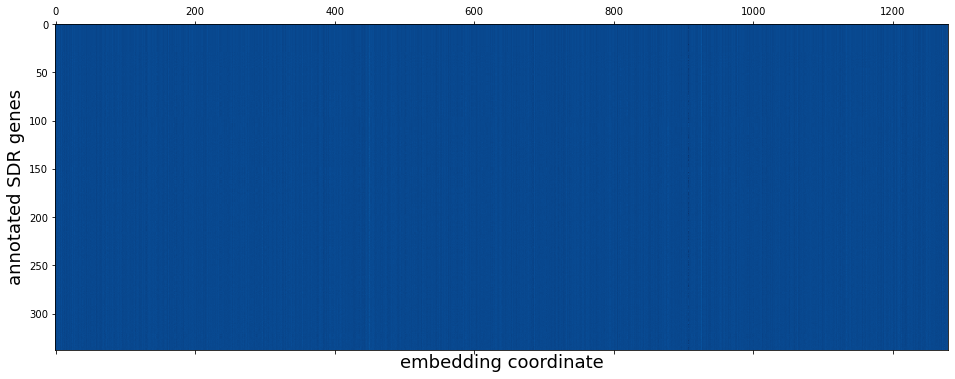

In [22]:
fig, ax = plt.subplots(figsize = (16, 6))

shw = ax.matshow(X, aspect='auto', cmap=plt.cm.Blues)
# plt.colorbar(shw)
xl = plt.xlabel('embedding coordinate', fontsize = 18)
xl = plt.ylabel('annotated SDR genes', fontsize = 18)

In [23]:
# These are the Y-values (classification values): 
y = df_UP_NAD_NADH_01.cofactor.values
print(list_err)
print(X.shape, y.shape)

[]
(338, 1280) (338,)


# EXERCISE 1:
## A classifier that predicts NAD(H) vs. NADP(H) cofactor usage.

#### [ACTION ITEM]: automate and organize computing both shuffled and non-shuffled classification scores

In [24]:
def classifier(X, y, model, shuffle):

    n_splits = 5
    n_classes = 2
    list_roc_auc = [] # store median roc_auc for each regularization parameter
    
    if model == 'logreg':
        reg_param_list = np.array([1e-2, 1e-1, 1e0, 1e1]) # l1 regularization
    elif model == 'xgbc':
        reg_param_list = np.array([10, 100])
    
    # shuffle or don't shuffle y
    y_shfl = y.copy()
    if shuffle: 
        random.shuffle(y_shfl)
    else:
        y_shfl = y.copy()

    for reg_param_temp in reg_param_list:   # For each regularization parameter: 
        roc_auc = [] #store auc_roc for each fold

        if model == 'logreg':
            clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
            # clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
        elif model == 'xgbc':
            clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1, eval_metric='logloss', use_label_encoder=False)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_shfl[train_index], y_shfl[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
            # fit model
            clf.fit(X_train, y_train)
            # predict on test set
            y_hat = clf.predict(X_test)
            # evalute classification score using AU-ROC   
            y_pred = clf.predict_proba(X_test)
            roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

        list_roc_auc.append( np.median(roc_auc) )
            
    df_accuracy = pd.DataFrame()
    df_accuracy['C_reg'] = reg_param_list
    df_accuracy['roc_auc'] = list_roc_auc

    return df_accuracy

True accuracies: 

In [25]:
model = 'logreg'

# true accuracy
shuffle = False 
df_accuracy = classifier( X, y, model, shuffle )

# accuracy after permutation
shuffle = True 
num_iter = 10
list_df_accuracy_SHFL = []
for ii in range(num_iter):
    print(ii, 'out of', num_iter)
    df_accuracy_SHFL = classifier(X, y, model, shuffle)
    list_df_accuracy_SHFL.append(df_accuracy_SHFL)

0 out of 10


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


1 out of 10
2 out of 10
3 out of 10
4 out of 10
5 out of 10
6 out of 10
7 out of 10


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


8 out of 10


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


9 out of 10


[PENDING]: Save results: 

Plot true data vs. shuffled accuracies plots: 

In [ ]:
metric = 'roc_auc'
model =  'log_reg' #'xgbc'
for C in df_accuracy.C_reg.unique():
    plot_real_vs_shuffled_metric(df_accuracy, list_df_accuracy_SHFL, C, metric, model, cols, xymin = 0, xymax = 1.1)

# Running predictions on unannotatd SDR proteins: 

In [33]:
file_in = '../../data/mohammed/uniprot-ipr002347.tab'
df_all = pd.read_csv(file_in, sep = '\t')
df_sdr_mtb = df_all[df_all.Organism.str.contains('H37Rv')].copy()

str_query = 'Rv\d\d\d\d[c]*'
list_rvid = [re.findall(str_query, g)[0] for g in df_sdr_mtb['Gene names'].tolist()]
df_sdr_mtb['Rv_ID'] = list_rvid

print(df_sdr_mtb.shape)
df_sdr_mtb.head(1)

(46, 10)


,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Annotation,Sequence,Rv_ID
12,P9WGT3,MABA_MYCTU,reviewed,3-oxoacyl-[acyl-carrier-protein] reductase Mab...,mabA fabG1 Rv1483 MTCY277.04,Mycobacterium tuberculosis (strain ATCC 25618 ...,247,5 out of 5,MTATATEGAKPPFVSRSVLVTGGNRGIGLAIAQRLAADGHKVAVTH...,Rv1483


Add one extra one: 

In [34]:
list_mtb_sdr = df_sdr_mtb.Entry.tolist()
# list_mtb_sdr.append('P9WQP7')

#### Load their embeddings: 

In [57]:
EMB_PATH_Mtb = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/mohammed/sdr_reprs_Mtb'
Xs_list = []
list_err = []
for entry in list_mtb_sdr:
    fn_full = os.path.join(EMB_PATH_Mtb, entry+'.pt')
    try:
        embs = torch.load(fn_full)
        Xs_list.append(embs['mean_representations'][EMB_LAYER])
    except:
        list_err.append(entry)
X_mtb = torch.stack(Xs_list, dim=0).numpy().copy()
X_mtb.shape

(46, 1280)

#### Run them through the classifier: 

In [36]:
reg_param_temp = 1e0
clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
X_train, y_train = SMOTE().fit_resample(X, y) # I guess you also use SMOTE when you train with all the data? 
clf.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', penalty='l1', solver='liblinear')

In [37]:
y_mtb = clf.predict(X_mtb)
df_sdr_mtb['NAD_NADP'] = y_mtb
df_sdr_mtb.NAD_NADP.value_counts()

0.0    24
1.0    22
Name: NAD_NADP, dtype: int64

In [38]:
# 0:=NAD, 1:=NADP
fn_out = '../../data/mohammed/SDR_Mtb_predictions.csv'
columns = ['Entry', 'Rv_ID', 'Annotation', 'Length', 'NAD_NADP']
df_sdr_mtb_v1 = df_sdr_mtb.sort_values(by='Rv_ID')[columns].copy()
df_sdr_mtb_v1.to_csv(fn_out, index = False)

### [PENDING]: Repeat for M. smeg and compare the ratios of NAD vs. NADP enzymes

# EXERCISE 2: 

## A classifier that predicts whether substrate is of a particular molecular structural class. 

[COMMENT]: Where does the input file below come from?

In [113]:
def plot_real_vs_shuffled_metric_many(df_true_vs_shlf, list_df_accuracy_SHFL, C, model, cols, xymin = 0.35, xymax = 0.85):

    df_C = df_true_vs_shlf[df_true_vs_shlf.C_reg == C]
    plt.figure(figsize=(7,7))
    plt.scatter(df_C.metric_true, df_C.metric_shfl_mean, color = cols[-3], s=100, edgecolors='k', linewidths=2)
    plt.errorbar(df_C.metric_true, df_C.metric_shfl_mean, 
                 yerr = [df_C.metric_shfl_mean-df_C.metric_shfl_pc5, df_C.metric_shfl_pc95-df_C.metric_shfl_mean], 
                 fmt = '.', markersize=1, capsize=5, ecolor='k')

    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.xlabel('classification score (ROC)', fontsize = 22)
    plt.ylabel('classification score (ROC)\nrandomized', fontsize = 22)

    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.tight_layout()
    # save to file: 
    path_fig = '../figures/Adrian_classification/'
    fn_fig = 'true_vs_shuffle_MANY'+metric+'_'+model+'_C_'+str(C)+'_'+version+'.png'
    plt.savefig(os.path.join(path_fig, fn_fig), dpi = 250)

In [116]:
path_in = '../../data/mohammed/'
list_mol_class = ['beta_keto_AA', 'sterol', 'sugar', 'x_acyl_coA', 'retinol', 'fabG', 'coA']
model = 'logreg'
df_true_vs_shlf = pd.DataFrame()

In [117]:
for mol_class in list_mol_class:
    
    fn = mol_class + '_cluster_classify.csv'
    file_in = os.path.join( path_in, fn )
    df_cluster_classify = pd.read_csv(file_in)

    # Load embeddings: 
    Xs_list = []
    list_err = []
    for entry in df_cluster_classify.Entry.values:
        fn_full = os.path.join(EMB_PATH, entry+'.pt')
        try:
            embs = torch.load(fn_full)
            Xs_list.append(embs['mean_representations'][EMB_LAYER])
        except:
            list_err.append(entry)
    X = torch.stack(Xs_list, dim=0).numpy()
    y = df_cluster_classify.compound_cluster.values


    # true accuracy
    shuffle = False 
    df_accuracy = classifier( X, y, model, shuffle )

    # accuracy after permutation
    shuffle = True 
    num_iter = 5
    list_df_accuracy_SHFL = []
    for ii in range(num_iter):
        print('molecular class:', mol_class, 'iteration:', ii, 'out of', num_iter)
        df_accuracy_SHFL = classifier(X, y, model, shuffle)
        list_df_accuracy_SHFL.append(df_accuracy_SHFL)

    # Store accuracies of true and shuffled datasets: 
    list_metric_true = []
    list_metric_shfl_pc95 = []
    list_metric_shfl_pc5 = []
    list_metric_shfl_mean = []

    list_C = df_accuracy.C_reg.unique()
    for C in list_C:
        metric_true = df_accuracy[df_accuracy.C_reg==C][metric].values[0]
        list_metric_shfl = [ df[df.C_reg == C][metric].values[0] for df in list_df_accuracy_SHFL ]
        # error bars: 
        metric_shfl_pc95 = np.percentile(list_metric_shfl, 95)
        metric_shfl_pc5 = np.percentile(list_metric_shfl, 5)
        metric_shfl_mean = np.median(list_metric_shfl)
        list_metric_true.append(metric_true)
        list_metric_shfl_pc95.append(metric_shfl_pc95)
        list_metric_shfl_pc5.append(metric_shfl_pc5)
        list_metric_shfl_mean.append(metric_shfl_mean)

    df_true_vs_shfl_temp = pd.DataFrame()
    df_true_vs_shfl_temp['mol_class'] = [mol_class]*len(list_metric_true)
    df_true_vs_shfl_temp['model'] = [model]*len(list_metric_true)
    df_true_vs_shfl_temp['C_reg'] = list_C
    df_true_vs_shfl_temp['metric_true'] = list_metric_true
    df_true_vs_shfl_temp['metric_shfl_pc95'] = list_metric_shfl_pc95
    df_true_vs_shfl_temp['metric_shfl_pc5'] = list_metric_shfl_pc5
    df_true_vs_shfl_temp['metric_shfl_mean'] = list_metric_shfl_mean

    df_true_vs_shlf = pd.concat([df_true_vs_shlf, df_true_vs_shfl_temp], axis=0)


molecular class: beta_keto_AA iteration: 0 out of 5


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


molecular class: beta_keto_AA iteration: 1 out of 5
molecular class: beta_keto_AA iteration: 2 out of 5


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


molecular class: beta_keto_AA iteration: 3 out of 5
molecular class: beta_keto_AA iteration: 4 out of 5
molecular class: sterol iteration: 0 out of 5
molecular class: sterol iteration: 1 out of 5


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


molecular class: sterol iteration: 2 out of 5
molecular class: sterol iteration: 3 out of 5


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


molecular class: sterol iteration: 4 out of 5


/home/ajinich/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


molecular class: sugar iteration: 0 out of 5


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [118]:
df_true_vs_shlf

,mol_class,model,C_reg,metric_true,metric_shfl_pc95,metric_shfl_pc5,metric_shfl_mean
0,beta_keto_AA,logreg,0.01,0.500000,0.500000,0.500000,0.500000
1,beta_keto_AA,logreg,0.10,0.667660,0.500000,0.500000,0.500000
2,beta_keto_AA,logreg,1.00,0.983871,0.558032,0.412524,0.500000
3,beta_keto_AA,logreg,10.00,0.991058,0.509594,0.444849,0.470665
0,sterol,logreg,0.01,0.500000,0.500000,0.500000,0.500000
1,sterol,logreg,0.10,0.715021,0.500000,0.500000,0.500000
2,sterol,logreg,1.00,0.901235,0.535437,0.446587,0.489091
3,sterol,logreg,10.00,0.955761,0.537937,0.455284,0.500535


In [114]:
for C in df_true_vs_shlf.C_reg.unique():
    plot_real_vs_shuffled_metric_many(df_true_vs_shlf, list_df_accuracy_SHFL, C, model, cols, xymin = 0.3, xymax = 1.05)

AttributeError: 'DataFrame' object has no attribute 'C_reg'

In [ ]:
metric = 'roc_auc'
model = 'logreg' # log_reg
for C in df_accuracy.C_reg.unique():
    plot_real_vs_shuffled_metric(df_accuracy, list_df_accuracy_SHFL, C, metric, model, cols, xymin = 0, xymax = 1.1)

# Run the classifier on the Mtb SDRs for all structural classes: 

In [73]:
path_in = '../../data/mohammed/'
reg_param_temp = 1e1
list_mol_class = ['sterol', 'sugar', 'x_acyl_coA', 'retinol', 'fabG', 'coA']

In [74]:
# mol_class = list_mol_class[0]
for mol_class in list_mol_class:
    
    fn = mol_class + '_cluster_classify.csv'
    file_in = os.path.join( path_in, fn )
    df_cluster_classify = pd.read_csv(file_in)

    # Load embeddings: 
    Xs_list = []
    list_err = []
    for entry in df_cluster_classify.Entry.values:
        fn_full = os.path.join(EMB_PATH, entry+'.pt')
        try:
            embs = torch.load(fn_full)
            Xs_list.append(embs['mean_representations'][EMB_LAYER])
        except:
            list_err.append(entry)
    print(mol_class, list_err)
    X = torch.stack(Xs_list, dim=0).numpy()
    y = df_cluster_classify.compound_cluster.values.copy()

    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
    X_train, y_train = SMOTE().fit_resample(X, y) # I guess you also use SMOTE when you train with all the data?????
    clf.fit(X_train, y_train)
#     clf.fit(X, y)
    y_mtb = clf.predict(X_mtb)
    df_sdr_mtb_v1[mol_class] = y_mtb

sterol []
sugar []
x_acyl_coA []
retinol []
fabG []
coA []


In [99]:
EMB_PATH

'/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/mohammed/sdr_reprs_45'

In [94]:
mol_class = 'beta_keto_AA'
fn = mol_class + '_cluster_classify.csv'
file_in = os.path.join( path_in, fn )
df_cluster_classify = pd.read_csv(file_in)

# Load embeddings: 
Xs_list = []
list_err = []
for entry in df_cluster_classify.Entry.values:
    fn_full = os.path.join(EMB_PATH, entry+'.pt')
    try:
        embs = torch.load(fn_full)
        Xs_list.append(embs['mean_representations'][EMB_LAYER])
    except:
        list_err.append(entry)
print(mol_class, list_err)
X = torch.stack(Xs_list, dim=0).numpy()
y = df_cluster_classify.compound_cluster.values.copy()

clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=reg_param_temp)
X_train, y_train = SMOTE().fit_resample(X, y) # I guess you also use SMOTE when you train with all the data?????
clf.fit(X_train, y_train)
#     clf.fit(X, y)
y_mtb = clf.predict(X_mtb)
df_sdr_mtb_v1[mol_class] = y_mtb

beta_keto_AA []


In [111]:
# mol_class = 'beta_keto_AA'
mol_class = 'sterol'
fn = mol_class + '_cluster_classify.csv'
file_in = os.path.join( path_in, fn )
df_cluster_classify = pd.read_csv(file_in)
df_cluster_classify[df_cluster_classify.Entry.isin(df_sdr_mtb_v1.Entry)]

,Entry,compound_cluster
77,I6Y778,0.0
195,P9WGS9,0.0
196,P9WGT1,1.0
198,P9WGT3,0.0


In [112]:
df_sdr_mtb_v1.sort_values(by = 'Annotation', ascending=False)

,Entry,Rv_ID,Annotation,Length,NAD_NADP,sterol,sugar,x_acyl_coA,retinol,fabG,coA,sterol_p0,sterol_p1,beta_keto_AA
227,P9WGS9,Rv3791,5 out of 5,254,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.891492,0.108508,0.0
128,P9WGT1,Rv2002,5 out of 5,260,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.953760,0.046240,1.0
129,I6Y778,Rv0242c,5 out of 5,454,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.998386,0.001614,1.0
12,P9WGT3,Rv1483,5 out of 5,247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957890,0.042110,0.0
1115,P9WGP9,Rv3085,3 out of 5,276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999906,0.000094,0.0
1529,P96825,Rv0148,3 out of 5,286,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.105826,0.894174,0.0
58666,P9WGS7,Rv0687,2 out of 5,275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.667336,0.332664,0.0
58731,P9WGR3,Rv2073c,2 out of 5,249,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.941418,0.058582,0.0
51781,P9WGQ9,Rv0769,2 out of 5,248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.367266,0.632734,0.0
55284,P9WGR5,Rv0484c,2 out of 5,251,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.936941,0.063059,1.0


In [98]:
df_sdr_mtb_v1.sort_values(by = 'Annotation', ascending=False)[['Entry', 'Rv_ID', 'Annotation', 'Length', 'NAD_NADP', mol_class]].head(8)

,Entry,Rv_ID,Annotation,Length,NAD_NADP,beta_keto_AA
227,P9WGS9,Rv3791,5 out of 5,254,1.0,0.0
128,P9WGT1,Rv2002,5 out of 5,260,0.0,1.0
129,I6Y778,Rv0242c,5 out of 5,454,0.0,1.0
12,P9WGT3,Rv1483,5 out of 5,247,1.0,0.0
1115,P9WGP9,Rv3085,3 out of 5,276,0.0,0.0
1529,P96825,Rv0148,3 out of 5,286,0.0,0.0
58666,P9WGS7,Rv0687,2 out of 5,275,0.0,0.0
58731,P9WGR3,Rv2073c,2 out of 5,249,1.0,0.0


In [109]:
fn_out = '../../data/mohammed/SDR_Mtb_predictions_101221.csv'
df_sdr_mtb_v1.to_csv(fn_out, index=False)

In [108]:
# 0:=NAD, 1:=NADP
columns = ['Entry', 'Rv_ID', 'Annotation', 'Length', 'fabG', 'acylCoA', 'sugar', 'sterol', 'NAD_NADP']

In [109]:
df_sdr_mtb[ ((df_sdr_mtb.fabG.values==1) | (df_sdr_mtb.acylCoA.values==1)) & (df_sdr_mtb.NAD_NADP.values==0)][columns]

,Entry,Rv_ID,Annotation,Length,fabG,acylCoA,sugar,sterol,NAD_NADP
129,I6Y778,Rv0242c,5 out of 5,454,0.0,1.0,0.0,0.0,0.0
1529,P96825,Rv0148,3 out of 5,286,0.0,1.0,0.0,0.0,0.0
51467,P9WGQ7,Rv1144,2 out of 5,250,0.0,1.0,0.0,0.0,0.0
52694,P9WGR9,Rv1350,2 out of 5,247,1.0,0.0,0.0,0.0,0.0
72321,O05842,Rv3224,1 out of 5,282,0.0,1.0,0.0,0.0,0.0
125491,P71853,Rv3548c,1 out of 5,304,0.0,1.0,0.0,0.0,0.0
256343,I6YB11,Rv3057c,1 out of 5,287,0.0,1.0,1.0,0.0,0.0
257346,O53547,Rv3502c,1 out of 5,317,0.0,1.0,0.0,0.0,0.0


In [ ]:
df_sdr_mtb[ (df_sdr_mtb.fabG.values==1) | (df_sdr_mtb.acylCoA.values==1) 
           | (df_sdr_mtb.sugar.values==1) | (df_sdr_mtb.sterol.values==1)][columns].sort_values(by=['acylCoA', 'fabG', 'Rv_ID'], ascending=False)

In [ ]:
# df_sdr_mtb[df_sdr_mtb.sugar.values==1][columns]
df_sdr_mtb[columns].sort_values(by='Rv_ID', ascending=True)

# OTHER: 

# EXERCISE 1B: 
## Repeat the above, but with training and test sets stratified by sequence similarity: 

Created a function called "strat_by_SSN" that takes in the set of clusters for the training set: 

In [350]:
thresh = 90
# clus_train = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] #used for the 35% datafile
# clus_train = list(np.arange(1, 60))
clus_train = random.sample(list(np.arange(1,64)), 55)
X_train, X_test, y_train, y_test = strat_by_SSN(thresh, clus_train, df_UP_NAD_NADH_01, X, Y)

fraction of enzymes in the training set:
0.66

fraction of enzymes in True category in the test set:
0.65


In [ ]:
C_list = [1e-1,1e0,1e1,1e2,1e3]
list_accuracy = []
list_log_loss = []
counter = 0
for C in C_list:  
    # C=1
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=13)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    confusion = confusion_matrix(y_test, y_hat)
    confusion = normalize(confusion, axis=1, norm='l1')
    
    y_pred = clf.predict_proba(X_test)
    list_log_loss.append(log_loss(y_test, y_pred))
    list_accuracy.append(accuracy_score(y_test, y_hat))

    col_names = ['NAD', 'NADP']
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(7,7))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":34})
    txt = heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS')
    plt.tight_layout()
    plt.savefig(os.path.join(path_fig, 'NAD_NADP_conf_SSN_strat_th'+str(thresh)+'_'+str(counter)+'.png'), dpi=250)
    counter += 1


In [ ]:
title_str = 'NAD/NADP classifier\nSSN stratification (thresh. '+str(thresh)+'%)'
file_name = 'NAD_NADP_acc_ll_SSN_th'+str(thresh)+'.png'
ymax = 1
plot_logloss_acc(C_list, list_accuracy, list_log_loss, title_str, file_name, ymax)

# EXERCISE 2B:
## Repeat the above, but with training and test sets stratified by sequence similarity: 

##### Load EFI-SSN clusters: 

In [335]:
thresh = 90

hand_picked = 0
if hand_picked:
    clus_train = [1, 2, 4, 8, 9, 11, 12, 13, 14, 15]
else:
    clus_train = random.sample(list(np.arange(1,64)), 50)
X_train, X_test, y_train, y_test = strat_by_SSN(thresh, clus_train, df_cluster_classify, X, Y)

fraction of enzymes in the training set:
0.61

fraction of enzymes in True category in the test set:
0.21


In [ ]:
C_list = [1e-1,1e0,1e1,1e2,1e3]
list_accuracy = []
list_log_loss = []
counter = 0
for C in C_list:  
    # C=1
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C, random_state=13)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    confusion = confusion_matrix(y_test, y_hat)
    confusion = normalize(confusion, axis=1, norm='l1')
    
    y_pred = clf.predict_proba(X_test)
    list_log_loss.append(log_loss(y_test, y_pred))
    list_accuracy.append(accuracy_score(y_test, y_hat))

    col_names = ['no sterol\nsubstrate', 'sterol\nsubstrate']
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(7,7))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":34})
    txt = heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS')
    plt.tight_layout()
    if hand_picked:
        plt.savefig(os.path.join(path_fig, 'sterol_conf_SSN_strat_th'+str(thresh)+'_'+str(counter)+'_PICKED.png'), dpi=250)
    else:
        plt.savefig(os.path.join(path_fig, 'sterol_conf_SSN_strat_th'+str(thresh)+'_'+str(counter)+'.png'), dpi=250)
    counter += 1

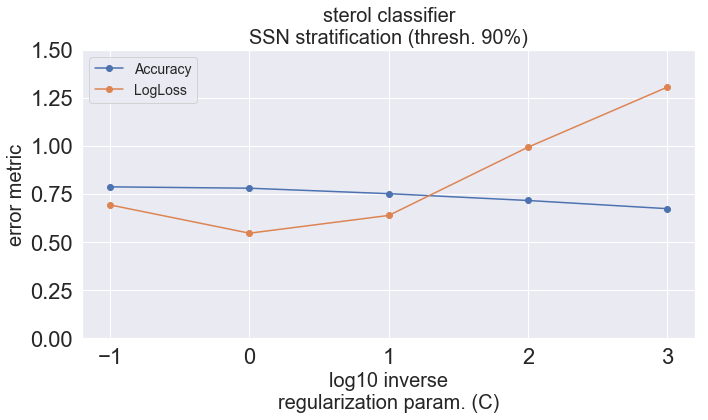

In [338]:
if hand_picked:
    title_str = 'sterol classifier\nSSN stratification (thresh. '+str(thresh)+'%)\nhand-picked clusters'
    file_name = 'sterol_acc_ll_SSN_th'+str(thresh)+'_PICKED.png'
else:
    title_str = 'sterol classifier\nSSN stratification (thresh. '+str(thresh)+'%)'
    file_name = 'sterol_acc_ll_SSN_th'+str(thresh)+'.png'
ymax = 1.5

plot_logloss_acc(C_list, list_accuracy, list_log_loss, title_str, file_name, ymax)

### alternative way to select clusters:

In [656]:
# Pick proteins in num_clus clusters to train on, and validate on proteins in the remainder of the clusters:
num_clus = 2
clus_train = np.arange(1, num_clus)
clus_test = np.arange(num_clus, df_ssn.ClusterNum.max()+1)

### alternative way to randomly pick from the cluster IDs: 


You need to find a smarter way to do this... partition the clusters such that you get the right number of proteins in the training / validation sets.

In [654]:
num_clus = df_ssn.ClusterNum.max()+1
list_num_clus = list(np.arange(1, num_clus))
num_to_sample = 8
clus_list_1 = random.sample(list_num_clus, 7)
clus_list_2 = [c for c in list_num_clus if c not in clus_train]

print(df_ssn[df_ssn['ClusterNum'].isin(clus_list_1)].shape[0] / df_ssn.shape[0])

list_train = df_ssn[df_ssn.ClusterNum.isin(clus_list_2)].Entry.tolist()
list_test = df_ssn[df_ssn.ClusterNum.isin(clus_list_1)].Entry.tolist()
len(list_train), len(list_test)

0.07650273224043716


(113, 28)

### Saving list of proteins with sterol substrates:

In [ ]:
df_sterol = df_cluster_classify[df_cluster_classify.compound_cluster.values == 1][['Entry']]
file_out = '../../data/mohammed/EFI_SSN_clusters/EFI_SSN_SDR_45/sterol.csv'
df_sterol.to_csv(file_out, index = False)

### Saving lists of genes in specific clusters: 

In [ ]:
clus_list = [1, 2, 3, 4, 8, 9, 11]
file_name = ''.join([str(c) for c in clus_list])
file_out = '../../data/mohammed/EFI_SSN_clusters/EFI_SSN_SDR_45/thresh_35_cluster_'+file_name+'.csv'
df_test = df_ssn[df_ssn.ClusterNum.isin(clus_list)][['Entry']]
df_test.to_csv(file_out, index = False)

In [ ]:
for i in range(1,18):
    clus_list = [i]
    file_name = ''.join([str(c) for c in clus_list])
    file_out = '../../data/mohammed/EFI_SSN_clusters/EFI_SSN_SDR_45/thresh_35_cluster_'+file_name+'.csv'
    df_test = df_ssn[df_ssn.ClusterNum.isin(clus_list)][['Entry']]
    df_test.to_csv(file_out, index = False)

## Understanding the structure of the EFI-SSN clusters: 

In [395]:
df_ssn.ClusterNum.value_counts().head(5)

1    117
2     56
3     28
4     27
5     19
Name: ClusterNum, dtype: int64

In [383]:
df_ssn.head(2)

,Entry,ClusterNum,Cluster Color,Taxonomy ID,Species
0,A0A1A9TAK5,1,#FF0000,39639,Narcissus pseudonarcissus
1,A0A3Q8GL18,1,#FF0000,54731,Nepeta racemosa


In [423]:
sterol_entries = df_sterol.Entry.tolist()
df_ssn[ (df_ssn.ClusterNum.values == 4) & (df_ssn.Entry.isin(sterol_entries))].Entry.tolist()

['O54939',
 'O57314',
 'O70503',
 'P37058',
 'P70385',
 'Q28IU1',
 'Q4R5G7',
 'Q53GQ0',
 'Q5E9H7',
 'Q5XG41',
 'Q6P3L6',
 'Q6P7R8',
 'Q6QA32',
 'Q6QA33',
 'Q8AVY8']

In [ ]:
clus_num = 1
list_prots_in_clus = df_ssn[df_ssn.ClusterNum.values==clus_num].Entry.tolist()
df_45[df_45.Entry.isin(list_prots_in_clus)]['EC_list'].value_counts()

## Digging deeper into the NAD/NADP double binding cases. Do they really use either cofactor? 

In [106]:
list_num_nad = []
list_num_nadp = []
for entry in list_UP_NAD_NADP:
#     entry = 'O14756'
    df_entry = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.Entry.values == entry]
    num_nad = df_entry[df_entry.ChEBI.isin(nad_nadh)].shape[0]
    num_nadp = df_entry[df_entry.ChEBI.isin(nadp_nadph)].shape[0]
    list_num_nad.append(num_nad)
    list_num_nadp.append(num_nadp)
    
df_num_nad_nadp = pd.DataFrame()
df_num_nad_nadp['Entry'] = list_UP_NAD_NADP
df_num_nad_nadp['num_nad'] = list_num_nad
df_num_nad_nadp['num_nadp'] = list_num_nadp

df_num_nad_nadp['frac_nad'] = np.array(list_num_nad) / (np.array(list_num_nad) + np.array(list_num_nadp))
df_num_nad_nadp['frac_nadp'] = np.array(list_num_nadp) / (np.array(list_num_nad) + np.array(list_num_nadp))

In [118]:
file_out = '../../data/mohammed/SDR_45_NAD_NADP.xlsx'
df_num_nad_nadp.to_excel(file_out, index = False)

### [QUICK FIX]: Generate embedding files for these sequences: 

In [50]:
file_in = '../../data/mohammed/rhea_test/uniprot-ipr002347.tab'
# file_in = '../../data/mohammed/uniprot-ipr002347_annot345.csv'
df = pd.read_csv(file_in, sep = '\t')

In [55]:
def df_to_fasta(df, file_out):
    with open(file_out, 'w') as fout: 
        for index, row in df.iterrows():
            fout.write('>'+row['Entry']+'\n')
            fout.write(row['Sequence']+'\n')

In [56]:
df_missing = df[df.Entry.isin(list_err)]
file_out = '../../data/mohammed/missing_sdr_45.fasta'
df_to_fasta(df_missing, file_out)

# Legacy:

In [ ]:
C_list = [1e-1,1e0,1e1,1e2,1e3]
list_accuracy = []
list_log_loss = []
path_fig = '../../figs/mohammed/'

counter = 0
for C_temp in C_list:

    # Train model, get accuracy, log-loss, and confusion matrix: 
    accuracy, confusion, log_loss_var, clf = log_regression(X, Y, n_classes=2, n_splits=5, norm_method='SMOTE', C=C_temp)
    list_accuracy.append(np.median(accuracy))
    list_log_loss.append(np.median(log_loss_var))

    # Plotting confusion matrix: 
    col_names = ['NAD', 'NADP']
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(7,7))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":34})
    txt = heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS')
    plt.tight_layout()
    plt.savefig(os.path.join(path_fig, 'NAD_NADP_conf_RAND_Y_'+str(counter)+'.png'), dpi=250)
    counter += 1

In [ ]:
title_str = 'NAD/NADP classifier\nrandom stratification'
file_name = 'NAD_NADP_acc_ll_random.png'
ymax = 1
plot_logloss_acc(C_list, list_accuracy, list_log_loss, title_str, file_name, ymax)

In [ ]:
C_list = [1e-1,1e0,1e1,1e2,1e3]
list_accuracy = []
list_log_loss = []
path_fig = '../../figs/mohammed/'

counter = 0
for C_temp in C_list:
    
    accuracy, confusion, log_loss_var, clf = log_regression(X, Y, n_classes=2, n_splits=5, norm_method='SMOTE', C=C_temp)
    list_accuracy.append(np.median(accuracy))
    list_log_loss.append(np.median(log_loss_var))
    
    col_names = ['no sterol\nsubstrate', 'sterol\nsubstrate']
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    plt.figure(figsize=(7,7))
    rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    sns.set(rc=rc)
    heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":34})
    txt = heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS')
    plt.tight_layout()
    plt.savefig(os.path.join(path_fig, 'sterol_conf_rand_'+str(counter)+'.png'), dpi=250)
    counter += 1
    

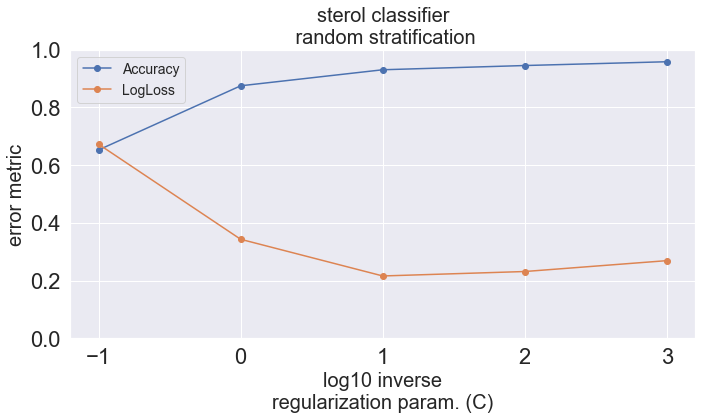

In [91]:
title_str = 'sterol classifier\n random stratification'
file_name = 'sterol_acc_ll_random.png'
ymax = 1
plot_logloss_acc(C_list, list_accuracy, list_log_loss, title_str, file_name, ymax)